## Purpose of this notebook is to demonstrate construction survey processing techniques to automatically process shot data into polylines.

1. Attempted geometry only "arm" algorithm
2. ML approach better since it considers geospatial relationship to ALL points not just those being processed. 

In [1]:
import string
import geopandas as gpd
import pandas as pd
import sklearn
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import numpy as np
from scipy import optimize 
import numpy as np 
import matplotlib.pyplot as plt
import pprint
import shapely as sh
from scipy import optimize 
from math import sqrt
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
st = pd.read_csv('/Users/connortluck/Desktop/Roadway_Geometry_Designed_Fit/Import/Survey_Text_Data/170_3250_Hamden_Skiff.txt')
st.columns = ['Point','Easting','Northing','Elevation','Point_Type']

In [3]:
st = gpd.GeoDataFrame(st)
st.dropna(inplace = True)
st

,Point,Easting,Northing,Elevation,Point_Type
0,59,696879.525,955230.238,68.830,CT GEODETIC SURVEY MONUMENT
1,3,696689.394,955593.962,70.170,CONTROL TRAVERSE POINT
2,4,696679.828,955834.323,53.935,CONTROL TRAVERSE POINT
3,5,696561.221,955616.176,51.890,CONTROL TRAVERSE POINT
4,6,696665.127,955535.884,69.670,CONTROL TRAVERSE POINT
...,...,...,...,...,...
2566,2876,696597.582,955771.280,67.845,ACTIVE PT FOR LOCATION SHOTS
2567,2780,696579.183,955698.362,67.410,ACTIVE PT FOR LOCATION SHOTS
2568,2781,696577.109,955701.867,67.451,ACTIVE PT FOR LOCATION SHOTS
2569,2782,696617.163,955733.794,67.213,ACTIVE PT FOR LOCATION SHOTS


In [4]:
'''view all unique points labels'''
point_type_list = st['Point_Type'].unique()
for a,b,c in zip(point_type_list[::3],point_type_list[1::3],point_type_list[2::3]):
    print ('{:<30}{:<30}{:<}'.format(a,b,c))

CT GEODETIC SURVEY MONUMENT   CONTROL TRAVERSE POINT        CONCRETE WALK
CHAIN LINK/WIRE FENCE         TOP OF CURB                   EDGE OF CONCRETE ROAD
GROUND AT STRUCTURE           BREAKLINE                     EDGE OF BITUMINOUS ROAD
TOP STRUCTURE                 WETLANDS (FIELD LOCATION)     BIT CONCRETE LIP CURBING
CONCRETE CURBING              CHECK SHOT                    GRANITE CURBING
GUIDE RAIL                    UTILITY POLE W/ LIGHT         GAS MAIN
PEDESTRIAN X-WALK BUTTON POLE BOARD FENCE                   SIGN-SINGLE POST
WATER GATE                    WATER MAIN                    ACTIVE PT FOR LOCATION SHOTS
SIGN-DOUBLE POST              CROSS WALK STRIPING           STORM MANHOLE
PVT MRK-BROKEN  LINE          PVT MRK-SOLID DBL LINE        PVT MRK-STOP BAR
TELEPHONE MANHOLE             BACK CONCRETE WALK            WOOD POST
EARTH TOP SLOPE               SIGN (LINEAR)                 SQUARE WOOD RAIL POST
C CB                          ELECTRIC TRANSFORMER  BOX     B

In [5]:
'''list of acceptable point label names to add to center of road search'''
point_label_list = ['PVT MRK-SOLID YELLOW LINE','PVT MRK-SOLID DBL LINE']

In [6]:
subsetDataFrame = st[st['Point_Type'].isin(point_label_list) ]
subsetDataFrame['Point_Type'].value_counts()

PVT MRK-SOLID YELLOW LINE    74
PVT MRK-SOLID DBL LINE       25
Name: Point_Type, dtype: int64

In [303]:
ep_df = st[st['Point_Type'] == 'GUIDE RAIL']
ep_df

,Point,Easting,Northing,Elevation,Point_Type
327,103,696793.874,955377.142,68.003,GUIDE RAIL
333,111,696774.689,955415.075,68.399,GUIDE RAIL
351,132,696716.450,955529.721,69.238,GUIDE RAIL
358,139,696712.702,955537.186,69.300,GUIDE RAIL
392,178,696662.021,955636.136,69.981,GUIDE RAIL
...,...,...,...,...,...
1835,1890,696823.829,955319.552,68.001,GUIDE RAIL
1836,1891,696816.443,955334.307,67.879,GUIDE RAIL
2054,2109,696693.124,955324.189,65.902,GUIDE RAIL
2055,2110,696708.990,955326.234,66.861,GUIDE RAIL


In [304]:
'''serialize all points'''
#create a list of letters for all upper case alphas
list_of_letters = [letter for letter in string.ascii_uppercase]

#create a list of keys which are 01 to 0.26
letter_key = list(range(1,27))
letter_dict_values = list(map(lambda x: str(x/100),letter_key))

#create the dictionary of replcement numbers for letters in points
alpha_replacement_dict = {list_of_letters[i]: letter_dict_values[i] for i in range(len(list_of_letters))} 

def find_replace(string, dictionary):
    # is the item in the dict?
    for item in string:
        # iterate by keys
        if item in dictionary.keys():
            # look up and replace
            string = string.replace(item,'')
            string = float(string) + float(dictionary[item])
    # return updated string
    return float(string)

processed_column = []
for index,row in ep_df.iterrows():
    working_string = row['Point']
    processed_column.append(find_replace(working_string,alpha_replacement_dict))
print(processed_column)
ep_df.drop('Point',axis=1,inplace=True)
ep_df.insert(0,'Point',processed_column)


[103.0, 111.0, 132.0, 139.0, 178.0, 224.0, 225.0, 226.0, 241.0, 242.0, 249.0, 250.0, 304.0, 305.0, 306.0, 309.0, 310.0, 317.0, 318.0, 380.0, 381.0, 384.0, 387.0, 388.0, 429.0, 432.0, 433.0, 436.0, 446.0, 463.0, 467.0, 472.0, 478.0, 486.0, 491.0, 492.0, 503.0, 535.0, 536.0, 540.0, 541.0, 547.0, 552.0, 554.0, 847.0, 848.0, 853.0, 961.0, 963.0, 974.0, 977.0, 978.0, 979.0, 981.0, 982.0, 983.0, 984.0, 985.0, 988.0, 989.0, 992.0, 993.0, 1265.0, 1266.0, 1271.0, 1272.0, 1599.0, 1603.0, 1606.0, 1608.0, 1890.0, 1891.0, 2109.0, 2110.0, 2111.0]


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [305]:
import pyproj
def coord_convert(self):
    '''create Lat and Long points from northing easting US COORDINATES'''
    #define coord systems.
    wgs84=pyproj.CRS("EPSG:4326") # Lat Long coords
    NAD83=pyproj.CRS("EPSG:2234") # N E coords

    #lat is northing.
    geo_lat = []
    geo_long = []
    for index,row in self.iterrows():
        geo_lat.append(row['Northing'])
        geo_long.append(row['Easting'])


    converted = pyproj.transform(NAD83, wgs84, geo_lat,geo_long)

    #latitude, Longitude Tuple
    return((converted[0],converted[1]))


'''run the above script on the point dataframe'''
ep_df['Latitude'] = coord_convert(ep_df)[0]
ep_df['Longitude'] = coord_convert(ep_df)[1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [306]:
ep_df

,Point,Easting,Northing,Elevation,Point_Type,Latitude,Longitude
327,103.0,696793.874,955377.142,68.003,GUIDE RAIL,41.373324,-72.912580
333,111.0,696774.689,955415.075,68.399,GUIDE RAIL,41.373272,-72.912442
351,132.0,696716.450,955529.721,69.238,GUIDE RAIL,41.373113,-72.912024
358,139.0,696712.702,955537.186,69.300,GUIDE RAIL,41.373103,-72.911997
392,178.0,696662.021,955636.136,69.981,GUIDE RAIL,41.372964,-72.911636
...,...,...,...,...,...,...,...
1835,1890.0,696823.829,955319.552,68.001,GUIDE RAIL,41.373406,-72.912790
1836,1891.0,696816.443,955334.307,67.879,GUIDE RAIL,41.373386,-72.912737
2054,2109.0,696693.124,955324.189,65.902,GUIDE RAIL,41.373048,-72.912773
2055,2110.0,696708.990,955326.234,66.861,GUIDE RAIL,41.373091,-72.912765


# 3 closest points algorithm

In [11]:
ep_df_sorted = ep_df.sort_values(['Point'],ascending = True)
ep_df_sorted

,Point,Easting,Northing,Elevation,Point_Type,Latitude,Longitude
327,103.0,696793.874,955377.142,68.003,GUIDE RAIL,41.373324,-72.912580
333,111.0,696774.689,955415.075,68.399,GUIDE RAIL,41.373272,-72.912442
351,132.0,696716.450,955529.721,69.238,GUIDE RAIL,41.373113,-72.912024
358,139.0,696712.702,955537.186,69.300,GUIDE RAIL,41.373103,-72.911997
392,178.0,696662.021,955636.136,69.981,GUIDE RAIL,41.372964,-72.911636
...,...,...,...,...,...,...,...
1835,1890.0,696823.829,955319.552,68.001,GUIDE RAIL,41.373406,-72.912790
1836,1891.0,696816.443,955334.307,67.879,GUIDE RAIL,41.373386,-72.912737
2054,2109.0,696693.124,955324.189,65.902,GUIDE RAIL,41.373048,-72.912773
2055,2110.0,696708.990,955326.234,66.861,GUIDE RAIL,41.373091,-72.912765


In [68]:
#distance to next point
distance_list = [0]
for index in range(len(ep_df_sorted)-1):
    y2 = ep_df_sorted.iloc[index+1]['Northing']
    x2 = ep_df_sorted.iloc[index+1]['Easting']
    y1 = ep_df_sorted.iloc[index]['Northing']
    x1 = ep_df_sorted.iloc[index]['Easting']
    distance_to_next_point = sqrt(((x2-x1)**2)+(y2-y1)**2)
    distance_list.append(round(distance_to_next_point,2))
ep_df_sorted['Distance_to_Next_Point'] = distance_list

The First Quartile Stats are as follows:
--------------------------------------------------
Point                        349.000000
Easting                   696577.309000
Northing                  955538.607000
Elevation                     53.157000
Latitude                      41.372732
Longitude                    -72.911991
Distance_to_Next_Point        16.500000
Name: 0.25, dtype: float64




The Third Quartile Stats are as follows:
--------------------------------------------------
Point                        983.500000
Easting                   696694.339000
Northing                  955748.213000
Elevation                     70.351500
Latitude                      41.373052
Longitude                    -72.911227
Distance_to_Next_Point        50.945000
Name: 0.75, dtype: float64




Inter-Quartile Range is as follows:
--------------------------------------------------
Point                     634.500000
Easting                   117.030000
Northing                  209.606

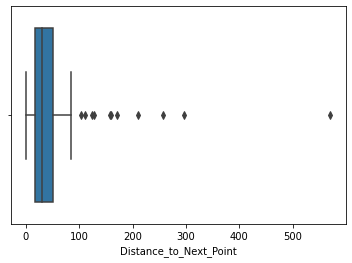

In [71]:
'''since we are trying to find linear items, scan through and remove any 
points from the linear item list that do not have a point within the 75 quartile.'''

'''z-score analysis to find the 75th quartile of points after they have
been ordered'''
import seaborn as sns
sns.boxplot(x=ep_df_sorted['Distance_to_Next_Point'])

Q1 = ep_df_sorted.quantile(0.25)
Q2 = ep_df_sorted.quantile(0.50)
Q3 = ep_df_sorted.quantile(0.75)
print("The First Quartile Stats are as follows:")
print("-"*50)
print(Q1)

print('\n'*3)
print("The Third Quartile Stats are as follows:")
print("-"*50)
print(Q3)

IQR = Q3 - Q1

print('\n'*3)
print("Inter-Quartile Range is as follows:")
print("-"*50)
print(IQR)


In [77]:
#acceptable distance to next point when seeking arms.
Q2 = ep_df_sorted.quantile(0.50)
Q2['Distance_to_Next_Point']

29.96

In [254]:
ep_df_processing=ep_df_sorted

In [255]:
clean_index = list(range(len(ep_df_processing)))
ep_df_processing['clean_index'] = clean_index
ep_df_processing

,Point,Easting,Northing,Elevation,Point_Type,Latitude,Longitude,Distance_to_Next_Point,clean_index
327,103.0,696793.874,955377.142,68.003,GUIDE RAIL,41.373324,-72.912580,0.00,0
333,111.0,696774.689,955415.075,68.399,GUIDE RAIL,41.373272,-72.912442,42.51,1
351,132.0,696716.450,955529.721,69.238,GUIDE RAIL,41.373113,-72.912024,128.59,2
358,139.0,696712.702,955537.186,69.300,GUIDE RAIL,41.373103,-72.911997,8.35,3
392,178.0,696662.021,955636.136,69.981,GUIDE RAIL,41.372964,-72.911636,111.17,4
...,...,...,...,...,...,...,...,...,...
1835,1890.0,696823.829,955319.552,68.001,GUIDE RAIL,41.373406,-72.912790,570.69,70
1836,1891.0,696816.443,955334.307,67.879,GUIDE RAIL,41.373386,-72.912737,16.50,71
2054,2109.0,696693.124,955324.189,65.902,GUIDE RAIL,41.373048,-72.912773,123.73,72
2055,2110.0,696708.990,955326.234,66.861,GUIDE RAIL,41.373091,-72.912765,16.00,73


In [256]:
ep_df_processing = ep_df_processing.sort_values(by=['clean_index']).copy()
ep_df_processing

,Point,Easting,Northing,Elevation,Point_Type,Latitude,Longitude,Distance_to_Next_Point,clean_index
327,103.0,696793.874,955377.142,68.003,GUIDE RAIL,41.373324,-72.912580,0.00,0
333,111.0,696774.689,955415.075,68.399,GUIDE RAIL,41.373272,-72.912442,42.51,1
351,132.0,696716.450,955529.721,69.238,GUIDE RAIL,41.373113,-72.912024,128.59,2
358,139.0,696712.702,955537.186,69.300,GUIDE RAIL,41.373103,-72.911997,8.35,3
392,178.0,696662.021,955636.136,69.981,GUIDE RAIL,41.372964,-72.911636,111.17,4
...,...,...,...,...,...,...,...,...,...
1835,1890.0,696823.829,955319.552,68.001,GUIDE RAIL,41.373406,-72.912790,570.69,70
1836,1891.0,696816.443,955334.307,67.879,GUIDE RAIL,41.373386,-72.912737,16.50,71
2054,2109.0,696693.124,955324.189,65.902,GUIDE RAIL,41.373048,-72.912773,123.73,72
2055,2110.0,696708.990,955326.234,66.861,GUIDE RAIL,41.373091,-72.912765,16.00,73


In [350]:
'''DND this is the code to find the four cloest points to first point in dataframe'''
import math

def Sort_Tuple(tup):  
    tup.sort(key = lambda x: x[4])  
    return tup

def point_to_point_geometrics(center_x,center_y,seek_x,seek_y):
    delta_x = seek_x - center_x
    delta_y = seek_y - center_y
    theta_radians = math.atan2(delta_y, delta_x)
    distance_to_next_point = sqrt(((seek_x-center_x)**2)+(seek_y-center_y)**2)
    return(theta_radians,distance_to_next_point)


def node_identifier(working_database):
    
    #set acceptable seek distnace
    acceptable_seek_distance = Q3['Distance_to_Next_Point'] 

    #establish point origin, select first point in dataframe of unprocessed points
    center_y = working_database.iloc[0]['Northing']
    center_x = working_database.iloc[0]['Easting']
    active_point_number = working_database.iloc[0]['Point']
    active_point_index = working_database.iloc[0].name

    '''establish lists for distance to all points and the 4 working points which will be selected based on distance'''
    distance_list_all_points = [] #this will be used to store distance and angle to all points.
    origin_node_list = [] #this will be used to store distnace and angle to four closest points.
    distance_deciding_list_1 = [] #for use later to decide which 4 points are closest and then begin further processing.
    distance_deciding_list_2 = []
    distance_deciding_list_3 = []
    distance_deciding_list_4 = []
    four_min_distances = []
    for g in range(len(working_database)): #skip the first value as that should be the working value from above.

        if working_database.iloc[g].name == active_point_index:
            pass
        else:
            
            # 1. establish what the seeking point is
            seek_y = working_database.iloc[g]['Northing']
            seek_x = working_database.iloc[g]['Easting']
            
            '''for printing only'''
            working_point_number = working_database.iloc[g]['Point']
            working_point_index = working_database.iloc[g].name
            
            '''establish quad 1 point'''
            
            if seek_x - center_x > 0 and seek_y - center_y > 0:
                
                # 2. plug into the angle function
                angle,distance_to_next_point = point_to_point_geometrics(center_x,center_y,seek_x,seek_y) 
                if distance_to_next_point == 0 or distance_to_next_point > acceptable_seek_distance:
                    pass
                else:
                    distance_deciding_list_1.append((active_point_number,working_point_number,active_point_index,working_point_index,distance_to_next_point,angle))

            '''establish quad 2 point'''
            if seek_x - center_x < 0 and seek_y - center_y > 0:

            # 2. plug into the angle function
                angle,distance_to_next_point = point_to_point_geometrics(center_x,center_y,seek_x,seek_y) 
                if distance_to_next_point == 0 or distance_to_next_point > acceptable_seek_distance:
                    pass
                else:
                    distance_deciding_list_2.append((active_point_number,working_point_number,active_point_index,working_point_index,distance_to_next_point,angle))

            '''establish quad 3 point'''
            if seek_x - center_x < 0 and seek_y - center_y < 0:

            # 2. plug into the angle function
                angle,distance_to_next_point = point_to_point_geometrics(center_x,center_y,seek_x,seek_y) 
                if distance_to_next_point == 0 or distance_to_next_point > acceptable_seek_distance:
                    pass
                else:
                    distance_deciding_list_3.append((active_point_number,working_point_number,active_point_index,working_point_index,distance_to_next_point,angle))

            '''establish quad 4 point'''
            if seek_x - center_x > 0 and seek_y - center_y < 0:

            # 2. plug into the angle function
                angle,distance_to_next_point = point_to_point_geometrics(center_x,center_y,seek_x,seek_y) 
                if distance_to_next_point == 0 or distance_to_next_point > acceptable_seek_distance:
                    pass
                else:
                    distance_deciding_list_4.append((active_point_number,working_point_number,active_point_index,working_point_index,distance_to_next_point,angle))

            
    #         text = "The distance from {0}, to point {1} at index position {2} to index position {3} is {4} and angle is {5}".format(active_point_number,working_point_number,active_point_index,working_point_index,distance_to_next_point,angle)
    #         print(text)

        '''find the four minimum distances from the first point to all other points'''


    
    if len(distance_deciding_list_1) > 0:
        four_min_distances.append(Sort_Tuple(distance_deciding_list_1)[0])
    else:
        pass
    if len(distance_deciding_list_2) > 0:
        four_min_distances.append(Sort_Tuple(distance_deciding_list_2)[0])
    else:
        pass
    if len(distance_deciding_list_3) > 0:
        four_min_distances.append(Sort_Tuple(distance_deciding_list_3)[0])
    else:
        pass
    if len(distance_deciding_list_4) > 0:
        four_min_distances.append(Sort_Tuple(distance_deciding_list_4)[0])
    else:
        pass
    
    
    
#     return(four_min_distances)
    return(four_min_distances)
    # print(four_min_distances)
    


In [164]:
node_identifier(ep_df_sorted)

[]

In [351]:
import math
def closest_next_point(tup):  
    tup.sort(key = lambda x: x[1]['distance'])  
    return tup  

def polyline_generator(spawn_point,active_dataframe):
    '''which polyline index are we looking at'''
    '''index of the point selected to start the polyline, NOT ORIGIN'''
    sp1_index = spawn_point[3]
    sp1_point_number = spawn_point[1]
    origin_index = spawn_point[2]

    '''origin to sp data'''
    origin_distance_acceptable = (spawn_point[4])*1.0 #acceptable distance is the origin to spawnpoint distance * 1.0
    origin_sp1_angle = spawn_point[5] #acceptable angle to next point is +/- 15 degrees from this angle.

    '''fixed angle threshold for search to next point''' 
    angle_threshold = 0.15 #in radians

    sp1_angle_upper = origin_sp1_angle + angle_threshold
    sp1_angle_lower = origin_sp1_angle - angle_threshold

    #######################################################################

    '''polyline creation from origin to sp1 with additions to follow'''
    polyline = {'starting angle':origin_sp1_angle,'polyline':[origin_index,sp1_index]}
    #establish the center point
    center_x = active_dataframe.loc[sp1_index]['Easting']
    center_y = active_dataframe.loc[sp1_index]['Northing']

    decision_list = [] #this list is going to be used to select the best candidate for addition to the polyline

    iteration_counter = 0

    while True:
        for i in range(len(active_dataframe)):
            iteration_counter += 1
            if active_dataframe.iloc[i].name == sp1_index: #avoid the div by zero error.
                pass
            else:
                '''for printing only''' #delete later
                point_index = active_dataframe.iloc[i].name
                point_number = active_dataframe.iloc[i]['Point']

                #seek x and seek y
                seek_y = active_dataframe.iloc[i]['Northing']
                seek_x = active_dataframe.iloc[i]['Easting']

                working_angle, distance_calc = point_to_point_geometrics(center_x,center_y,seek_x,seek_y)

                if distance_calc <= origin_distance_acceptable and working_angle <= sp1_angle_upper and working_angle >= sp1_angle_lower:
                    decision_list.append(((active_dataframe.iloc[i]),{'angle':working_angle,'distance':distance_calc,'delta_distance':working_angle-origin_sp1_angle}))
                else:
                    pass
            #########################################################
        '''pick the best point'''
        if len(decision_list) != 0:
            '''add the best point of the list to the polyline list'''
            polyline['polyline'].append(closest_next_point(decision_list)[0][0].name)

            center_x = closest_next_point(decision_list)[0][0]['Easting']
            center_y = closest_next_point(decision_list)[0][0]['Northing']
            origin_sp1_angle = closest_next_point(decision_list)[0][1]['angle']
            sp1_index = closest_next_point(decision_list)[0][0].name
            #empty the decision list
            decision_list = []
        else:
            return(polyline)
            break




    # print(decision_list)
    # print(sp1_polyline)




In [123]:
'''this function creates the polyline arms '''
def arm_creation(four_min_distances,active_dataframe):
    preprocessed_polylines=[]
    for seed in four_min_distances:
        preprocessed_polylines.append(polyline_generator(seed,active_dataframe,set_distance))
    return(preprocessed_polylines)

'''this function looks up geometry information for index lists'''
def index_to_attributes(list_of_index_positions,ep_df):
    polyline_all_attributes_list = []
    for i in list_of_index_positions:
        polyline_all_attributes_list.append(ep_df.loc[i])
    return(polyline_all_attributes_list)

'''this function turns attribute list into a shpely line '''
def attribute_to_shapely(polyline_all_attributes_list):
    long_lat_list = []
    for item in polyline_all_attributes_list:
        long_lat_list.append((item['Longitude'],item['Latitude']))
    shapely_object = sh.geometry.LineString(long_lat_list)
    return(shapely_object)

'''this function takes in all arms and cretes a list of polylines using other functions'''
def shapely_list_creator(arm_list,ep_df):
    shapley_list = []
    attribute_list = []
    #create list of attributes from index lists
    for item in arm_list:
        attribute_list.append(index_to_attributes(item['polyline'],full_dataframe))
    #create shaplely lines from attribute list
    for g in attribute_list:
        shapley_list.append(attribute_to_shapely(g))
    return(shapley_list)


In [124]:

angle_threshold=.05
def straight_angle_check(mylist):
    common_bearing_working_list = mylist.copy()
    '''this function will attempt to return a list which combines any line strings which share a common bearing'''
    combined_index_values_list = []
    for i in range(len(common_bearing_working_list)):
        for j in range(i + 1, len(common_bearing_working_list)):
            #add a buffer = to the angle threshold and then inverse sign and see if any angles pass this filter.
            index1_angle_upper = common_bearing_working_list[i]['starting angle'] + angle_threshold
            index1_angle_lower = common_bearing_working_list[i]['starting angle'] - angle_threshold
            
            if common_bearing_working_list[i]['starting angle'] > 0 and common_bearing_working_list[j]['starting angle'] < 0 or common_bearing_working_list[i]['starting angle'] < 0 and common_bearing_working_list[j]['starting angle'] > 0: 
            
                combined_angles = abs(common_bearing_working_list[i]['starting angle']) + abs(common_bearing_working_list[j]['starting angle']) 
            
                if combined_angles > (math.pi-.1) and combined_angles < (math.pi+.1):
            
                #set the origin point, should be common in all lists
                    origin = common_bearing_working_list[i]['polyline'][0]

                    L_1 = common_bearing_working_list[i]['polyline'].copy() #going in direction one
                    L_2 = common_bearing_working_list[j]['polyline'].copy() #going in direction two

                    '''pop off the origin of list 2 and reverse then add L2 to L1.'''
                    try:
                        L_2.remove(origin)
                        results = L_2[::-1] + L_1
                        combined_index_values_list.append({'starting angle': common_bearing_working_list[i]['starting angle'], 
                                                           'polyline':results,
                                                           'combined':(i,j)})
                    except:
                        results = L_2[::-1] + L_1
                        combined_index_values_list.append(results)
                else:
                    pass
            else:
                pass
    #                 print((common_bearing_working_list[i]['starting angle'],common_bearing_working_list[j]['starting angle'],index2_angle))
        if len(combined_index_values_list) == 0:
            None
        else:
            return combined_index_values_list


In [125]:
def polyline_selector(original_polyline_list, shared_bearing_polyline=None):
    '''this function will take all the arms originally generated as the shared bearing line and find the longest one using shapely'''
    shapely_list = []
    length_list = []
    if shared_bearing_polyline == None:
        combined_polyline_list = original_polyline_list.copy()
    else:
        combined_polyline_list = original_polyline_list.copy() + shared_bearing_polyline.copy()
    
    for polyline in combined_polyline_list:
        shapely_list.append(attribute_to_shapely(index_to_attributes(polyline['polyline'],ep_df)))
    if shared_bearing_polyline == None:
        pass
    else:
        for polyline in combined_polyline_list:
            shapely_list.append(attribute_to_shapely(index_to_attributes(polyline['polyline'],ep_df)))
    
    for shapely_line in shapely_list:
        length_list.append(shapely_line.length)
    
    max_index = length_list.index(max(length_list)) 
    return(combined_polyline_list[max_index]) #this is the longest and therefore best line from original lines and common bearing line. 
    
def dataframe_row_removal(polyline_data, processing_df):
    rows_for_removal = polyline_data['polyline']
    new_dataframe = processing_df.drop(rows_for_removal)
    return(new_dataframe.copy())
    
    
    

In [419]:
working_dataframe.head(1)

,Point,Easting,Northing,Elevation,Point_Type,Latitude,Longitude,Distance_to_Next_Point,clean_index
351,132.0,696716.45,955529.721,69.238,GUIDE RAIL,41.373113,-72.912024,128.59,802096


In [494]:
import random

def index_randomizer_and_resort(working_dataframe):
    '''takes in dataframe, adds random numbers to clean index column and sorts for repeated precessing'''
    processing_dataframe = working_dataframe.copy()
    clean_index_randomizer_list = []
    clean_index_list=list(processing_dataframe['clean_index'])

    new_index = random.sample(range(1, len(working_dataframe)+1), len(working_dataframe))
    
    processing_dataframe['clean_index'] = new_index
    new_dataframe = processing_dataframe.sort_values(by=['clean_index']).copy()
    
    return(new_dataframe)



In [505]:
'''important'''
working_dataframe = ep_df_sorted.copy()
working_dataframe.loc[1139]

Point                            982
Easting                       696664
Northing                      955646
Elevation                     70.359
Point_Type                GUIDE RAIL
Latitude                      41.373
Longitude                   -72.9116
Distance_to_Next_Point         18.64
clean_index                       54
Name: 1139, dtype: object

In [506]:
working_dataframe = index_randomizer_and_resort(working_dataframe)

In [507]:
'''GENERAL WORK FLOW FOR HELP FORMING THE CLASS AND LOGIC'''
#establish the dataframe: 
'''working_dataframe'''

#empty list to store polylines
all_polylines = []
arm_number = 0
while True:
    if len(working_dataframe) <= 1:
        break
    else:
        #establish the four closest points to the first point in the dataframe
        
        while True:
            four_min_distances = node_identifier(working_dataframe)
            print('#####   ARM NUMBER IS: {0}     #######'.format(str(arm_number)))
            print('this is the four min distance report')
            print(four_min_distances)
            print('\n')

            if len(four_min_distances) == 0:
                working_dataframe = index_randomizer_and_resort(working_dataframe)
            
            else:
                break

        
        #run arm creation which will create four amrs off that polyline
        arms = arm_creation(four_min_distances,working_dataframe)
        print('this is the generated arms of polylines')
        print(arms)
        print('\n')
        
        
        #check if the arms have a common bearing angle and merge
        matching_bearing_polyline = straight_angle_check(arms)
        print('this is the generated arms of matching bearing polyline')
        print(matching_bearing_polyline)
        print('\n')
        #select the best arm
        
        best_polyline = polyline_selector(arms,matching_bearing_polyline)
        
        
        if len(best_polyline['polyline']) > 2:
            print('this is the best polyline')
            print(best_polyline)
            print('\n')
            
            arm_number+=1
            all_polylines.append(best_polyline)
            working_dataframe = dataframe_row_removal(best_polyline,working_dataframe)
        else:
            print('polyline too short,retry')
            print('\n')
            best_polyline = []
            
            working_dataframe = index_randomizer_and_resort(working_dataframe)
            four_min_distances = []
            print(working_dataframe.head(1))
            
            



#####   ARM NUMBER IS: 0     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528), (984.0, 178.0, 1141, 392, 8.277541905677504, -2.6668151821422468)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}, {'starting angle': -2.6668151821422468, 'polyline': [1141, 392]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
564  380.0  696474.147  955672.227     52.197  GUIDE RAIL  41.372449   

     Longitude  Distance_to_Next_Point  clean_index  
564 -72.911503                  171.25            1  
#####   ARM NUMBER IS: 0     #######
this is the four min distance report
[(380.0, 381.0, 564, 565, 36.939663290297915, 0.6714855251892938), (380.0, 478.0, 564, 659, 38.325002230934174, -0.9029014107763254)]


this is the generated arms of polylines
[{'starting angle': 0

this is the generated arms of polylines
[{'starting angle': 2.1018306093909445, 'polyline': [1680, 1676]}, {'starting angle': -1.0566083942974167, 'polyline': [1680, 1683]}]


this is the generated arms of matching bearing polyline
[{'starting angle': 2.1018306093909445, 'polyline': [1683, 1680, 1676], 'combined': (0, 1)}]


this is the best polyline
{'starting angle': 2.1018306093909445, 'polyline': [1683, 1680, 1676], 'combined': (0, 1)}


#####   ARM NUMBER IS: 6     #######
this is the four min distance report
[(1891.0, 103.0, 1836, 327, 48.41690805898651, 2.055717714781449), (1891.0, 1890.0, 1836, 1835, 16.500394571069403, -1.106687963270404)]


this is the generated arms of polylines
[{'starting angle': 2.055717714781449, 'polyline': [1836, 327, 333]}, {'starting angle': -1.106687963270404, 'polyline': [1836, 1835]}]


this is the generated arms of matching bearing polyline
[{'starting angle': 2.055717714781449, 'polyline': [1835, 1836, 327, 333], 'combined': (0, 1)}]


this is t

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 7     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1139  982.0  696663.561  955645.897     70.359  GUIDE RAIL  4

#####   ARM NUMBER IS: 9     #######
this is the four min distance report
[(491.0, 486.0, 672, 667, 24.49292216118729, 0.7048798102879831), (491.0, 492.0, 672, 673, 21.484005888164084, -2.4287658922166093), (491.0, 541.0, 672, 721, 47.7431760673484, -0.4137285058816423)]


this is the generated arms of polylines
[{'starting angle': 0.7048798102879831, 'polyline': [672, 667]}, {'starting angle': -2.4287658922166093, 'polyline': [672, 673]}, {'starting angle': -0.4137285058816423, 'polyline': [672, 721]}]


this is the generated arms of matching bearing polyline
[{'starting angle': 0.7048798102879831, 'polyline': [673, 672, 667], 'combined': (0, 1)}]


this is the best polyline
{'starting angle': 0.7048798102879831, 'polyline': [673, 672, 667], 'combined': (0, 1)}


#####   ARM NUMBER IS: 10     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms o

this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,ret

this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1139  982.0  696663.561  955645.897     70.359  GUIDE RAIL  41.372968   

      Longitude  Distance_to_Next_Point  clean_index  
1139   -72.9116                   18.64            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


   

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Po

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting 

this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index  
1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37

this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


  

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting 

this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.9

2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is t

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1

this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAI

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting a

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Poin

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RA

this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type 

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,ret

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_T

this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Poi

this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
351  132.0  696716.45  955529.721     69.238  GUIDE RAIL  41.373113   

     Longitude  Distance_to_Next_Point  clean_index  
351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108 


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starti

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the g

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.3

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle

this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  

1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.

polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149   

     Longitude  Distance_to_Next_Point  clean_index  
721 -72.911183                    38.7            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
th

1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890

this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index  
1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949  

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'

this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Poin

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Poin

2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': 

432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1139  982.0  696663.561  955645.897     70.359  GUIDE

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
351  132.0  696716.45  955529.721     69.238  GUIDE RAIL  41.373113   

     Longitude  Distance_to_Next_Point  clean_index  
351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

 

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Poin

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
351  132.0  696716.45  955529.721     69.238  GUIDE RAIL  41.373113   

     Longitude  Distance_to_Next_Point  clean_index  
351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of 

1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting an

this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index

351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.59628595878049

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the 

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'sta

this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Lati

653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


th

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.3731

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.37265

this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index  
1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
20

this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41

430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index  
1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


poly

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL

1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


    

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting an

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.05

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0

[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  4

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     

430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.41675719298

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point  

this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.372615   

      Longitude  Distance_to_Next_Point  clean_index  
1012 -72.911557                   47.74            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitud

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   L

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.37309

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is th

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   L

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  4

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'startin

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,ret

this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 

506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.26939027101

      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min dista

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry



this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  9

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle':

this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  4

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
351  132.0  696716.45  955529.721     69.238  GUIDE RAIL  41.373113   

     Longitude  Distance_to_Next_Point  clean_index  
351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated

this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149  

this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   La

2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
351  132.0  696716.45  955529.721     69.238  GUIDE RAIL  41.373113   

     Longitude  Distance_to_Next_Point  clean_index  
351 -72.912024                  128.59            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.036103640

this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index 

this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index

1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the genera

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.3

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generat

this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     P

this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149   

     Longitude  Distance_to_Next_Point  clean_index  
721 -72.911183                    38.7            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too 

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generate

this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149   

     Longitude  Distance_to_Next_Point  clean_index  
721 -72.911183                    38.7            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polyli

this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry



#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polyline

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this 

this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.37

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Poin

this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


  

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1011  847.0  696497.52  955627.899     52.165  GUIDE RAIL  41.372512   

      Longitude  Distance_to_Next_Point  clean_index  
1011 -72.911665                   209.6            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generat

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149   

     Longitude  Distance_to_Next_Point  clean_index  
721 -72.911183                    38.7            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'startin

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this 

this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is t

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


po

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting 

this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point

this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.3

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generate

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(847.0, 478.0, 1011, 659, 14.242626618603536, 1.5453066948092997)]


this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362.253     68.336  GUIDE RAIL  41.373143   

     Longitude  Distance_to_Next_Point  clean_index  
431 -72.912634                   16.41            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated ar

this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitud

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type   Latitude  \
1138  981.0  696654.59  955662.239      70.36  GUIDE RAIL  41.372944   

      Longitude  Distance_to_Next_Point  clean_index  
1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Ty

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1139  982.0  696663.561  955645.897     70.359  GUIDE RAIL  41.372968   

      Longitude  Distance_to_Next_Point  clean_index  
1139   -72.9116                   18.64            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this i

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.373091   

      Longitude  Distance_to_Next_Point  clean_index  
2055 -72.912765                    16.0            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'startin

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of poly

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this 

this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1140  983.0  696666.252  955642.693     70.118  GUIDE RAIL  41.372976   

      Longitude  Distance_to_Next_Point  clean_index  
1140 -72.911612                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'starting angle': -0.7248354606090406, 'polyline': [1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry




#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle':

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'st

this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting   Northing  Elevation  Point_Type   Latitude  \
1141  984.0  696669.383  955639.92     70.267  GUIDE RAIL  41.372984   

      Longitude  Distance_to_Next_Point  clean_index  
1141 -72.911622                    4.18            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(984.0, 983.0, 1141, 1140, 4.182426329201733, 2.4167571929807528)]


this is the generated arms of polylines
[{'starting angle': 2.4167571929807528, 'polyline': [1141, 1140]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1012  848.0  696534.868  955657.641     52.272  GUIDE RAIL  41.

this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  30

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(848.0, 472.0, 1012, 653, 28.482305805596166, 1.0844738761879187), (848.0, 478.0, 1012, 659, 40.10316996206471, -2.7446474726975816)]


this is the generated arms of polylines
[{'starting angle': 1.0844738761879187, 'polyline': [1012, 653]}, {'starting angle': -2.7446474726975816, 'polyline': [1012, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2054  2109.0  696693.124  955324.189     65.902  GUIDE RAIL  41.373048   

      Longitude  Distance_to_Next_Point  clean_index  
2054 -72.912773                  123.73            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2109.0, 2110.0, 2054, 2055, 15.997249169706928, 0.128185234865521)]


this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is th

this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
20

this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(225.0, 226.0, 431, 432, 17.620115890599177, 1.6462362668016777), (225.0, 224.0, 431, 430, 16.40845931213961, -1.823091716203711)]


this is the generated arms of polylines
[{'starting angle': 1.6462362668016777, 'polyline': [431, 432]}, {'starting angle': -1.823091716203711, 'polyline': [431, 430]}]


this is the generated arms of matching bearing polyline
None


polyline too short,r

this is the generated arms of polylines
[{'starting angle': 0.128185234865521, 'polyline': [2054, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE 

this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  226.0  696726.513  955379.823     68.441  GUIDE RAIL  41.37314   

     Longitude  Distance_to_Next_Point  clean_index  
432  -72.91257                   17.62            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type  Latitude  \
432  2

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type  Latitude  \
1017  853.0  696580.131  955694.095     52.745  GUIDE RAIL  41.37274   

      Longitude  Distance_to_Next_Point  clean_index  
1017 -72.911424                   58.12            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(853.0, 472.0, 1017, 653, 33.881698260153286, -2.802378623181583)]


this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation  Point_Type  

1138 -72.911541                   32.55            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(981.0, 982.0, 1138, 1139, 18.642419505053265, -1.0687568363101017)]


this is the generated arms of polylines
[{'starting angle': -1.0687568363101017, 'polyline': [1138, 1139]}]


this

this is the generated arms of polylines
[{'starting angle': 1.5453066948092997, 'polyline': [1011, 659]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(982.0, 981.0, 1139, 1138, 18.642419505053265, 2.0728358172796915), (982.0, 983.0, 1139, 1140, 4.184148300446336, -0.8722023825718096)]


this is the generated arms of polylines
[{'starting angle': 2.0728358172796915, 'polyline': [1139, 1138]}, {'starting angle': -0.8722023825718096, 'polyline': [1139, 1140, 1141]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point    Easting    Northing  Elevation  Point_Type   Latitude  \
653  472.0  696548.18  955682.821     52.443  GUIDE RAIL  41.372652   

     Longitude  Distance_to_Next_Point  clean_index  
653 -72.911465                   31.71            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(472.0, 853.0, 653, 1017, 33.881698260153286, 0.33921403040821035), (472.0, 848.0, 653, 1012, 28.482305805596166, -2.0571187774018744)]


this is the generated arms of polylines
[{'starti

this is the generated arms of polylines
[{'starting angle': -2.802378623181583, 'polyline': [1017, 653]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


      Point    Easting    Northing  Elevation 

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
430  224.0  696723.745  955346.364     67.842  GUIDE RAIL  41.373132   

     Longitude  Distance_to_Next_Point  clean_index  
430 -72.912692                  296.27            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(224.0, 225.0, 430, 431, 16.40845931213961, 1.3185009373860823), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.3185009373860823, 'polyline': [430, 431]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


this is the generated a

      Point     Easting    Northing  Elevation  Point_Type   Latitude  \
1145  988.0  696605.385  955647.739      70.38  GUIDE RAIL  41.372809   

      Longitude  Distance_to_Next_Point  clean_index  
1145 -72.911593                   34.89            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starting angle': 1.0424108673484311, 'polyline': [2056, 430]}, {'starting angle': -2.4336663346935334, 'polyline': [2056, 2055]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
431  225.0  696727.841  955362

this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting   Northing  Elevation  Point_Type   Latitude  \
506  305.0  696656.915  955518.32     68.829  GUIDE RAIL  41.372949   

     Longitude  Distance_to_Next_Point  clean_index  
506 -72.912065                   16.19            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2110.0, 2111.0, 2055, 2056, 7.902995444800591, 0.7079263188962598), (2110.0, 2109.0, 2055, 2054, 15.997249169706928, -3.013407418724272)]


this is the generated arms of polylines
[{'starting angle': 0.7079263188962598, 'polyline': [2055, 2056]}, {'starting angle': -3.013407418724272, 'polyline': [2055, 2054]}]


this is the g

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(226.0, 224.0, 432, 430, 33.57330047811663, -1.6533364842402154), (226.0, 225.0, 432, 431, 17.620115890599177, -1.4953563867881157)]


this is the generated arms of polylines
[{'starting angle': -1.6533364842402154, 'polyline': [432, 430]}, {'starting angle': -1.4953563867881157, 'polyline': [432, 431]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
659  478.0  696497.883  955642.137     52.186  GUIDE RAIL  41.372514   

     Longitude  Distance_to_Next_Point  clean_index  
659 -72.911613                   64.69            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
721  541.0  696729.259  955760.661      53.67  GUIDE RAIL  41.373149   

     Longitude  Distance_to_Next_Point  clean_index  
721 -72.911183                    38.7            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[]


#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(983.0, 982.0, 1140, 1139, 4.184148300446336, 2.2693902710179836), (983.0, 984.0, 1140, 1141, 4.182426329201733, -0.7248354606090406)]


this is the generated arms of polylines
[{'starting angle': 2.2693902710179836, 'polyline': [1140, 1139]}, {'star

this is the generated arms of polylines
[{'starting angle': 0.33921403040821035, 'polyline': [653, 1017]}, {'starting angle': -2.0571187774018744, 'polyline': [653, 1012]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


     Point     Easting    Northing  Elevation  Point_Type   Latitude  \
358  139.0  696712.702  955537.186       69.3  GUIDE RAIL  41.373103   

     Longitude  Distance_to_Next_Point  clean_index  
358 -72.911997                    8.35            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(139.0, 132.0, 358, 351, 8.35306704154464, -1.1054890127260077)]


this is the generated arms of polylines
[{'starting angle': -1.1054890127260077, 'polyline': [358, 351]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point    Easting    Northing  Elevation  Point_Type   Latitude  \
2055  2110.0  696708.99  955326.234     66.861  GUIDE RAIL  41.37309

#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(478.0, 848.0, 659, 1012, 40.10316996206471, 0.3969451808922116), (478.0, 847.0, 659, 1011, 14.242626618603536, -1.5962859587804934)]


this is the generated arms of polylines
[{'starting angle': 0.3969451808922116, 'polyline': [659, 1012]}, {'starting angle': -1.5962859587804934, 'polyline': [659, 1011]}]


this is the generated arms of matching bearing polyline
None


polyline too short,retry


       Point     Easting    Northing  Elevation  Point_Type   Latitude  \
2056  2111.0  696714.994  955331.373     67.079  GUIDE RAIL  41.373108   

      Longitude  Distance_to_Next_Point  clean_index  
2056 -72.912747                     7.9            1  
#####   ARM NUMBER IS: 15     #######
this is the four min distance report
[(2111.0, 224.0, 2056, 430, 17.358285687242812, 1.0424108673484311), (2111.0, 2110.0, 2056, 2055, 7.902995444800591, -2.4336663346935334)]


this is the generated arms of polylines
[{'starti

KeyboardInterrupt: 

In [497]:
'''this function looks up geometry information for index lists'''
def index_to_attributes(list_of_index_positions,ep_df):
    polyline_all_attributes_list = []
    for i in list_of_index_positions:
        polyline_all_attributes_list.append(ep_df.loc[i])
    return(polyline_all_attributes_list)

'''this function turns attribute list into a shpely line '''
def attribute_to_shapely(polyline_all_attributes_list):
    long_lat_list = []
    for item in polyline_all_attributes_list:
        long_lat_list.append((item['Longitude'],item['Latitude']))
    shapely_object = sh.geometry.LineString(long_lat_list)
    return(shapely_object)





In [508]:
'''turn in to a function later maybe? '''

plotting_shapes = []
for i in all_polylines:
    plotting_shapes.append(attribute_to_shapely(index_to_attributes(i['polyline'],ep_df)))


In [509]:
import geopandas as gpd
plotting_geo_shapes = pd.DataFrame(plotting_shapes,columns = ['geometry'])


In [510]:
plotting_geo_shapes.geometry

0     LINESTRING (-72.91136047463526 41.372960792152...
1     LINESTRING (-72.91119350746926 41.372807657087...
2     LINESTRING (-72.91143516332924 41.372902956921...
3     LINESTRING (-72.91125219889493 41.372850212850...
4     LINESTRING (-72.91198599015327 41.372951677138...
5     LINESTRING (-72.91092469893941 41.372544720797...
6     LINESTRING (-72.91279041324428 41.373406407597...
7     LINESTRING (-72.91125638817807 41.373202913867...
8     LINESTRING (-72.91212270176786 41.372939858390...
9     LINESTRING (-72.91116347205543 41.372984578312...
10    LINESTRING (-72.9116358592199 41.3729639613055...
11    LINESTRING (-72.91101888462359 41.372739265616...
12    LINESTRING (-72.9120299271319 41.3729550154993...
13    LINESTRING (-72.91150308578592 41.372448531764...
14    LINESTRING (-72.91139236454852 41.372719438840...
Name: geometry, dtype: object

In [511]:
geo_names = list(range(0,len(plotting_geo_shapes)))

In [512]:
plotting_geo_shapes['name'] = geo_names

In [513]:
import plotly.express as px
import geopandas as gpd
import shapely.geometry
import numpy as np
import wget

# download a zipped shapefile
wget.download("https://plotly.github.io/datasets/ne_50m_rivers_lake_centerlines.zip")

# open a zipped shapefile with the zip:// pseudo-protocol
geo_df = gpd.read_file("zip://ne_50m_rivers_lake_centerlines.zip")

lats = []
lons = []
names = []

for feature, name in zip(plotting_geo_shapes.geometry, plotting_geo_shapes.name):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)

fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names,
                     mapbox_style="stamen-terrain", zoom=15)
fig.show()

In [504]:
'''STEP 1 of 3'''
#DONE
#need to choose the best line of all the arms and the combined lines
#DONE
''' check the lengths of the generated polylines and append together shorter lines if that makes sense'''

' check the lengths of the generated polylines and append together shorter lines if that makes sense'

In [85]:
'''STEP 2 of 3'''
#DONE
'''once the polyline is created and finalized, the index items need to be popped off the list and the prgram needs to be run again on the updated database.'''

'once the polyline is created and finalized, the index items need to be popped off the list and the prgram needs to be run again on the updated database.'

In [ ]:
'''STEP 3 of 3'''

'''split function which will review polylines shapely lines and break if they cross the roadway lines. '''

In [151]:
x = closest_next_point(decision_list)[0][0]['Easting']
y = closest_next_point(decision_list)[0][0]['Northing']
closest_next_point(decision_list)[0][1]['angle']

In [37]:
import shapely as sh
processed_geometry = []
for item in polyline_list:
    if len(item) <= 1:
        processed_geometry.append(sh.geometry.Point(item))
    else:
        processed_geometry.append(sh.geometry.LineString(item))
print(processed_geometry)
        

[]


In [61]:
class DivIcon():
    def __init__(self, html='', size=(30,30), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

In [30]:
"""All points graphed here, no training"""
import folium
import folium.plugins
from folium.features import *

folium_map_og = folium.Map(location=(41.372038,-72.909929),
                        zoom_start=20,
                        max_zoom = 40,
                        tiles='cartodbpositron')
    
# map all points in green
for index,row in ep_df.iterrows():
    color="#339237"
    folium.CircleMarker(location=(row['Latitude'],row['Longitude']),
                        radius=2,
                        fill=True,
                        popup='Point',
                        color=color).add_to(folium_map_og)  
    folium.map.Marker(location=(row['Latitude'],row['Longitude']),
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(20,0),
        html=row.name
        )
    ).add_to(folium_map_og)

# #map fitted in orange
# for index,row in cleaned.key_points[cleaned.key_points['Point Type'] == 'point_of_intersection'].iterrows():
#     color="#33f5ee"
#     folium.CircleMarker(location=(row['Latitude'],row['Longitude']),
#                         radius=4,
#                         fill=True,
#                         color=color,
#                         popup=(row['Latitude'],row['Longitude'])).add_to(folium_map_og) 

# #clean_Curves
# for index,row in cleaned.output.iterrows():
#     color="#0000ff"
#     folium.CircleMarker(location=(row['Latitude'],row['Longitude']),
#                         radius=4,
#                         fill=True,
#                         color=color,
#                         popup=(row['Latitude'],row['Longitude'])).add_to(folium_map_og) 
    
# for index,row in tangent_test.iterrows():
#     color= '#F39C12'
#     folium.CircleMarker(location=(row['Latitude'],row['Longitude']),
#                         radius=4,
#                         fill=True,
#                         color=color,
#                         popup=(row['Latitude'],row['Longitude'])).add_to(folium_map_og) 


folium_map_og

    

In [ ]:
#####   ARM NUMBER IS: 1     #######
this is the four min distance report
8.35306704154464
[(132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854), (132.0, 306.0, 351, 507, 57.51263075177895, -3.111159857613079), (132.0, 226.0, 351, 432, 150.23539653815877, -1.5037645878025254), (132.0, 552.0, 351, 732, 186.1876029654222, 1.560124092512448)]


this is the generated arms of polylines
[{'starting angle': 2.0361036408637854, 'polyline': [351, 358]}, {'starting angle': -3.111159857613079, 'polyline': [351, 507]}, {'starting angle': -1.5037645878025254, 'polyline': [351, 432]}, {'starting angle': 1.560124092512448, 'polyline': [351, 732]}]


this is the generated arms of matching bearing polyline
[{'starting angle': -1.5037645878025254, 'polyline': [732, 351, 432], 'combined': (2, 3)}]


this is the best polyline
{'starting angle': -1.5037645878025254, 'polyline': [732, 351, 432], 'combined': (2, 3)}

In [ ]:
#####   ARM NUMBER IS: 0     #######
this is the four min distance report
[(103.0, 111.0, 327, 333, 42.50854871668964, 2.0390414352558883), (103.0, 225.0, 327, 431, 67.69076310709985, -2.9198231287812946), (103.0, 1891.0, 327, 1836, 48.41690805898651, -1.085874938808344)]


this is the generated arms of polylines
[{'starting angle': 2.0390414352558883, 'polyline': [327, 333]}, {'starting angle': -2.9198231287812946, 'polyline': [327, 431]}, {'starting angle': -1.085874938808344, 'polyline': [327, 1836, 1835]}]


this is the generated arms of matching bearing polyline
[{'starting angle': 2.0390414352558883, 'polyline': [1835, 1836, 327, 333], 'combined': (0, 2)}]


this is the best polyline
{'starting angle': 2.0390414352558883, 'polyline': [1835, 1836, 327, 333], 'combined': (0, 2)}


#####   ARM NUMBER IS: 1     #######
this is the four min distance report
[(132.0, 552.0, 351, 732, 186.1876029654222, 1.560124092512448), (132.0, 139.0, 351, 358, 8.35306704154464, 2.0361036408637854), (132.0, 306.0, 351, 507, 57.51263075177895, -3.111159857613079), (132.0, 226.0, 351, 432, 150.23539653815877, -1.5037645878025254)]


this is the generated arms of polylines
[{'starting angle': 1.560124092512448, 'polyline': [351, 732]}, {'starting angle': 2.0361036408637854, 'polyline': [351, 358]}, {'starting angle': -3.111159857613079, 'polyline': [351, 507]}, {'starting angle': -1.5037645878025254, 'polyline': [351, 432, 431]}]


this is the generated arms of matching bearing polyline
[{'starting angle': 1.560124092512448, 'polyline': [431, 432, 351, 732], 'combined': (0, 3)}]


this is the best polyline
{'starting angle': 1.560124092512448, 'polyline': [431, 432, 351, 732], 'combined': (0, 3)}


#####   ARM NUMBER IS: 2     #######
this is the four min distance report
[(139.0, 547.0, 358, 727, 206.4617366631147, 1.394594420595731), (139.0, 309.0, 358, 510, 55.050408654319526, 3.0899442826820627), (139.0, 306.0, 358, 507, 54.52237035385426, -2.9717642794196184), (139.0, 224.0, 358, 430, 191.1412659081526, -1.512990114809845)]


this is the generated arms of polylines
[{'starting angle': 1.394594420595731, 'polyline': [358, 727]}, {'starting angle': 3.0899442826820627, 'polyline': [358, 510]}, {'starting angle': -2.9717642794196184, 'polyline': [358, 507]}, {'starting angle': -1.512990114809845, 'polyline': [358, 430]}]


this is the generated arms of matching bearing polyline
None


this is the best polyline
{'starting angle': 1.394594420595731, 'polyline': [358, 727]}


#####   ARM NUMBER IS: 3     #######
this is the four min distance report
[(178.0, 983.0, 392, 1140, 7.803563929425781, 0.997757238617721), (178.0, 961.0, 392, 1121, 17.67165428018512, 2.033431662314555), (178.0, 985.0, 392, 1142, 45.38300477050375, -2.6959693680322685), (178.0, 250.0, 392, 453, 147.45035847007026, -1.5015516163846219)]


this is the generated arms of polylines
[{'starting angle': 0.997757238617721, 'polyline': [392, 1140]}, {'starting angle': 2.033431662314555, 'polyline': [392, 1121, 1123]}, {'starting angle': -2.6959693680322685, 'polyline': [392, 1142]}, {'starting angle': -1.5015516163846219, 'polyline': [392, 453, 2054]}]


this is the generated arms of matching bearing polyline
None


this is the best polyline
{'starting angle': -1.5015516163846219, 'polyline': [392, 453, 2054]}


#####   ARM NUMBER IS: 4     #######
this is the four min distance report
[(224.0, 541.0, 430, 721, 414.3336920948156, 1.5574878199595075), (224.0, 241.0, 430, 444, 112.21980597468986, 1.811558368776979), (224.0, 2111.0, 430, 2056, 17.358285687242812, -2.099181786241362)]


this is the generated arms of polylines
[{'starting angle': 1.5574878199595075, 'polyline': [430, 721]}, {'starting angle': 1.811558368776979, 'polyline': [430, 444, 445]}, {'starting angle': -2.099181786241362, 'polyline': [430, 2056]}]


In [330]:
2.0390414352558883+abs(-1.085874938808344)

3.1249163740642323

In [ ]:
#####   ARM NUMBER IS: 0     #######
this is the four min distance report
[(103.0, 111.0, 327, 333, 42.50854871668964, 2.0390414352558883), (103.0, 225.0, 327, 431, 67.69076310709985, -2.9198231287812946), (103.0, 1891.0, 327, 1836, 48.41690805898651, -1.085874938808344)]


this is the generated arms of polylines
[{'starting angle': 2.0390414352558883, 'polyline': [327, 333]}, {'starting angle': -2.9198231287812946, 'polyline': [327, 431]}, {'starting angle': -1.085874938808344, 'polyline': [327, 1836, 1835]}]


this is the generated arms of matching bearing polyline
None


this is the best polyline
{'starting angle': -1.085874938808344, 'polyline': [327, 1836, 1835]}

#####   ARM NUMBER IS: 1     #######
this is the four min distance report
[(111.0, 241.0, 333, 444, 87.51819689640884, 2.6634220566466134), (111.0, 226.0, 333, 432, 59.69615129979112, -2.5098848732445593)]


this is the generated arms of polylines
[{'starting angle': 2.6634220566466134, 'polyline': [333, 444]}, {'starting angle': -2.5098848732445593, 'polyline': [333, 432]}]


this is the generated arms of matching bearing polyline
None


this is the best polyline
{'starting angle': 2.6634220566466134, 'polyline': [333, 444]}

In [ ]:
: [1132, 721, 1135], 'combined':

In [ ]:
847.0
1271.0

In [80]:
g = [444, 333, 432]
for i in g:
    print(ep_df.loc[i]["Point"])

241.0
111.0
226.0


In [77]:
for i in all_polylines:
    print(i['polyline'])

[327, 1836, 1835]
[444, 333, 432]
[510, 351, 507]
[511, 358, 506]
[392, 1121, 1123]
[430, 2054]
[1676, 1680, 1683, 1685, 1150, 1149, 1146, 1145, 1142, 519, 518, 445, 431, 2055]
[452, 1141, 715, 673]
[453, 1139, 716, 672]
[505, 1140, 720, 667]
[659, 564, 565, 568, 571, 572]
[613, 616, 617, 620, 630, 647, 649, 653]
[684, 1017, 1012, 1011]
[721, 1135]
[727, 732, 734, 1138]
[1132, 1400, 1399]
[1134, 2056]
[1136, 1406, 1405]


In [233]:
{'starting angle': 2.0390414352558883, 'polyline': [327, 333, 351, 358, 392, 1121, 1123, 1136, 1135, 684, 1134, 1132, 1406, 1405, 1400, 1399]}
{'starting angle': -1.085874938808344, 'polyline': [327, 1836, 1835]}
{'starting angle': -1.0911649618080557, 'polyline': [327, 1835]}
{'starting angle': 3.1018131713048964, 'polyline': [327, 432]}

{'starting angle': 3.1018131713048964, 'polyline': [327, 432]}

In [ ]:
seek_x = ep_df_processing.iloc[g]['Northing']

In [63]:
ep_df_sorted

,Point,Easting,Northing,Elevation,Point_Type,Distance_to_Next_Point,Delta_Slope,Break_Point_List
327,103.0,696793.874,955377.142,68.003,GUIDE RAIL,0.00,0.000000,Pass
333,111.0,696774.689,955415.075,68.399,GUIDE RAIL,42.51,0.931546,Pass
351,132.0,696716.450,955529.721,69.238,GUIDE RAIL,128.59,0.652461,Break
358,139.0,696712.702,955537.186,69.300,GUIDE RAIL,8.35,0.742515,Pass
392,178.0,696662.021,955636.136,69.981,GUIDE RAIL,111.17,0.612575,Break
...,...,...,...,...,...,...,...,...
1835,1890.0,696823.829,955319.552,68.001,GUIDE RAIL,570.69,-0.678652,Break
1836,1891.0,696816.443,955334.307,67.879,GUIDE RAIL,16.50,-0.739394,Pass
2054,2109.0,696693.124,955324.189,65.902,GUIDE RAIL,123.73,-1.597834,Break
2055,2110.0,696708.990,955326.234,66.861,GUIDE RAIL,16.00,5.993750,Pass
